In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Online vs batch for simple, stationary distrribution

We will compare an online model vs a batch model for a simple case. We will generate two stationary distributions, train initial models, then for new samples generate predictions. The accuracy of the two approaches will be compared. The online model will be updated, whereas the batch model will not.

## Generate some data

Define a generator to produce data, and a function to collect a batch of size n from the generator

In [2]:
def generate_lin_cls(mean_a, mean_b, cov_a, cov_b, seed = 1234):
    np.random.seed(seed)
    while True:
        if np.random.uniform() > 0.5:
            yield np.random.multivariate_normal(mean_a, cov_a, 1)[0], np.array([0], dtype = 'int64')
        else:
            yield np.random.multivariate_normal(mean_b, cov_b, 1)[0], np.array([1],  dtype = 'int64')

            
def collect_batch(batch_size, n_features, data_gen):
    x = np.empty([batch_size, n_features])
    y = np.empty(batch_size, dtype = 'int64')
    for i in range(batch_size):
        x_, y_ = next(data_gen)
        x[i,:] = x_
        y[i] = y_
        
    return x, y

In [3]:
# initialise generator 
gen = generate_lin_cls(mean_a = [-0.5, -0.5], 
                       mean_b = [0.5, 0.5], 
                       cov_a = [[1.0,0.0], [0.0, 1.0]], 
                       cov_b = [[1.0,0.0], [0.0, 1.0]]
                      )

### Quick visualisation

collect_batch returns a tuple of np arrays: features (x) and outcome (y). We can collect 200 points from our generator and plot them:

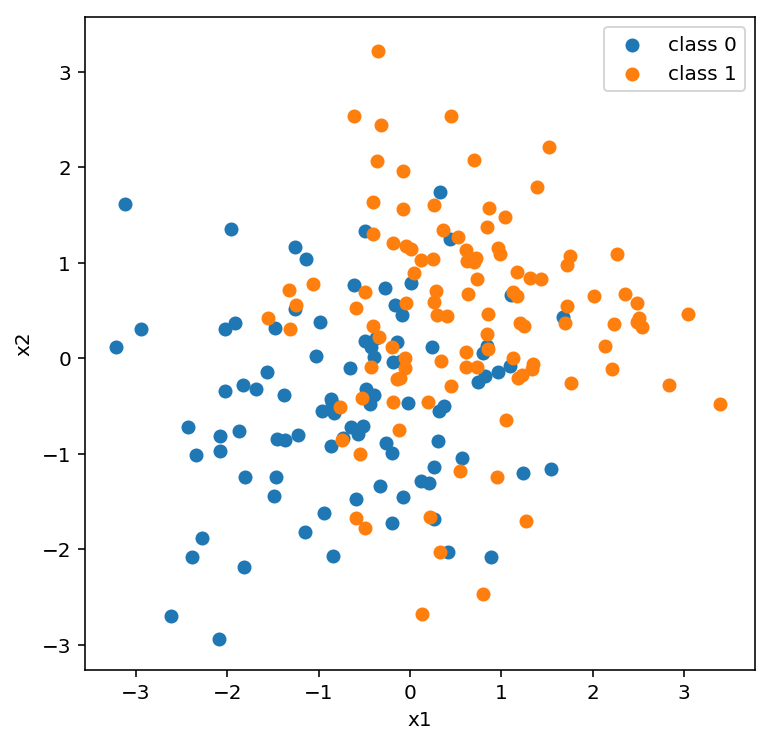

In [6]:
X_initial, y_initial = collect_batch(200, 2, gen)

fig, ax = plt.subplots(1, 1, figsize = (6,6))

for label in [0, 1]:
    mask = (y_initial == label)
    x = X_initial[mask, 0]
    y = X_initial[mask, 1]
    ax.scatter(x, y, label = 'class {}'.format(label))
    
# ax.set_ylim((-3, 3))   
# ax.set_xlim((-3, 3))
ax.legend()
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.savefig('simple_dist.svg', bbox_inches = 'tight', pad_inches = 0.5, dpi = 800);

We see two classes that are reasonably well seperated. However, we question that any additional information could improve a linear model to this data. We hypothesise that an online model will struggle to outperform a batch model: we have enough information to train our model, and as we expect the convergence of a liner model to outperform a stochastic model, it would be suprising if the online model massively outperformed the batch model.

## Train initial SGD model 

In [7]:
# scale the data: SGD models can become unstable
# when converging if data not scaled
scale = StandardScaler(with_mean = True, with_std = True)
scale.fit(X_initial)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [8]:
# log loss fuction is equialent to a logistic regression using
# stochastic gradient descent
sgd_est = SGDClassifier(loss = 'log',
                        penalty = 'l1',
                        max_iter = 500,
                        random_state = 1234,
                        warm_start= False)

# candidate hyperparameters
sgd_param_grid = dict(alpha = [0.001, 0.01, 0.1, 1, 10],
                      eta0 = [0.001, 0.01, 0.1, 1, 10],
                      l1_ratio = [0., 0.15 ,0.25, 0.5, 0.75],
                      learning_rate = ['optimal', 'constant'] 
                      )

# grid search with CV
grid_search_sgd = GridSearchCV(estimator = sgd_est,
                              param_grid = sgd_param_grid,
                              scoring = 'accuracy',
                              n_jobs = 3,
                              cv = 3,
                              refit = True,
                              verbose = 1)

grid_search_sgd.fit(scale.transform(X_initial), y_initial);

Fitting 3 folds for each of 250 candidates, totalling 750 fits


[Parallel(n_jobs=3)]: Done 750 out of 750 | elapsed:    3.9s finished


In [9]:
print('Chosen params: {}\n\nTrain Accuracy: {:0.3f}'.format(grid_search_sgd.best_params_,
                                                        grid_search_sgd.best_score_))

# extract best model
sgd_cls =  grid_search_sgd.best_estimator_

Chosen params: {'alpha': 0.001, 'eta0': 0.001, 'l1_ratio': 0.0, 'learning_rate': 'constant'}

Train Accuracy: 0.770


## Train a logistic regression model

In [11]:
lr_est = LogisticRegression()

# hyperparameters
lr_param_grid = dict(penalty = ['l1', 'l2'],
                     C = [0.001, 0.01, 0.1, 1, 10])

# grid search with CV
grid_search_lr = GridSearchCV(estimator = lr_est,
                              param_grid = lr_param_grid,
                              scoring = 'accuracy',
                              n_jobs = 3,
                              cv = 3,
                              refit = True,
                              verbose = 1)

grid_search_lr.fit(scale.transform(X_initial), y_initial);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    0.1s finished


In [12]:
print('Chosen params: {}\n\nTrain Accuracy: {:0.3f}'.format(grid_search_lr.best_params_,
                                                        grid_search_lr.best_score_))

# extract model
lr_cls =  grid_search_lr.best_estimator_

Chosen params: {'C': 0.001, 'penalty': 'l2'}

Train Accuracy: 0.780


We see the cross validation accuracy for both models are roughly equal to each other. Next, we will generate new data, and compare our online model (SGD) with the batch model (logisitic regression).

## Compare the models as we obtain new data

We will generate batches of 20 data points for 500 iterations, and compare the accuracy of both models on this data. The online model (SGD) will be updated after scoring the new data points, whereas the batch model (logistic regression) will not.

In [13]:
# we will run 500 iterations
nsteps = 500
# initialise empty array to hold results
update_result = np.empty((nsteps, 3))

In [14]:
for i in range(nsteps):

    # generate new points
    features, outcome = collect_batch(20, 2, gen)
    
    # scale
    features = scale.transform(features)

    # predict
    pred_sgd = sgd_cls.predict(features)
    pred_lr = lr_cls.predict(features)

    # assess accuracy
    acc_sgd = np.sum(pred_sgd == outcome) / len(pred_sgd)
    acc_lr = np.sum(pred_lr == outcome) / len(pred_lr)
    
    update_result[i, 0] = i
    update_result[i, 1] = acc_sgd
    update_result[i, 2] = acc_lr


    # update model
    sgd_cls.partial_fit(features, outcome, classes=np.unique(outcome))

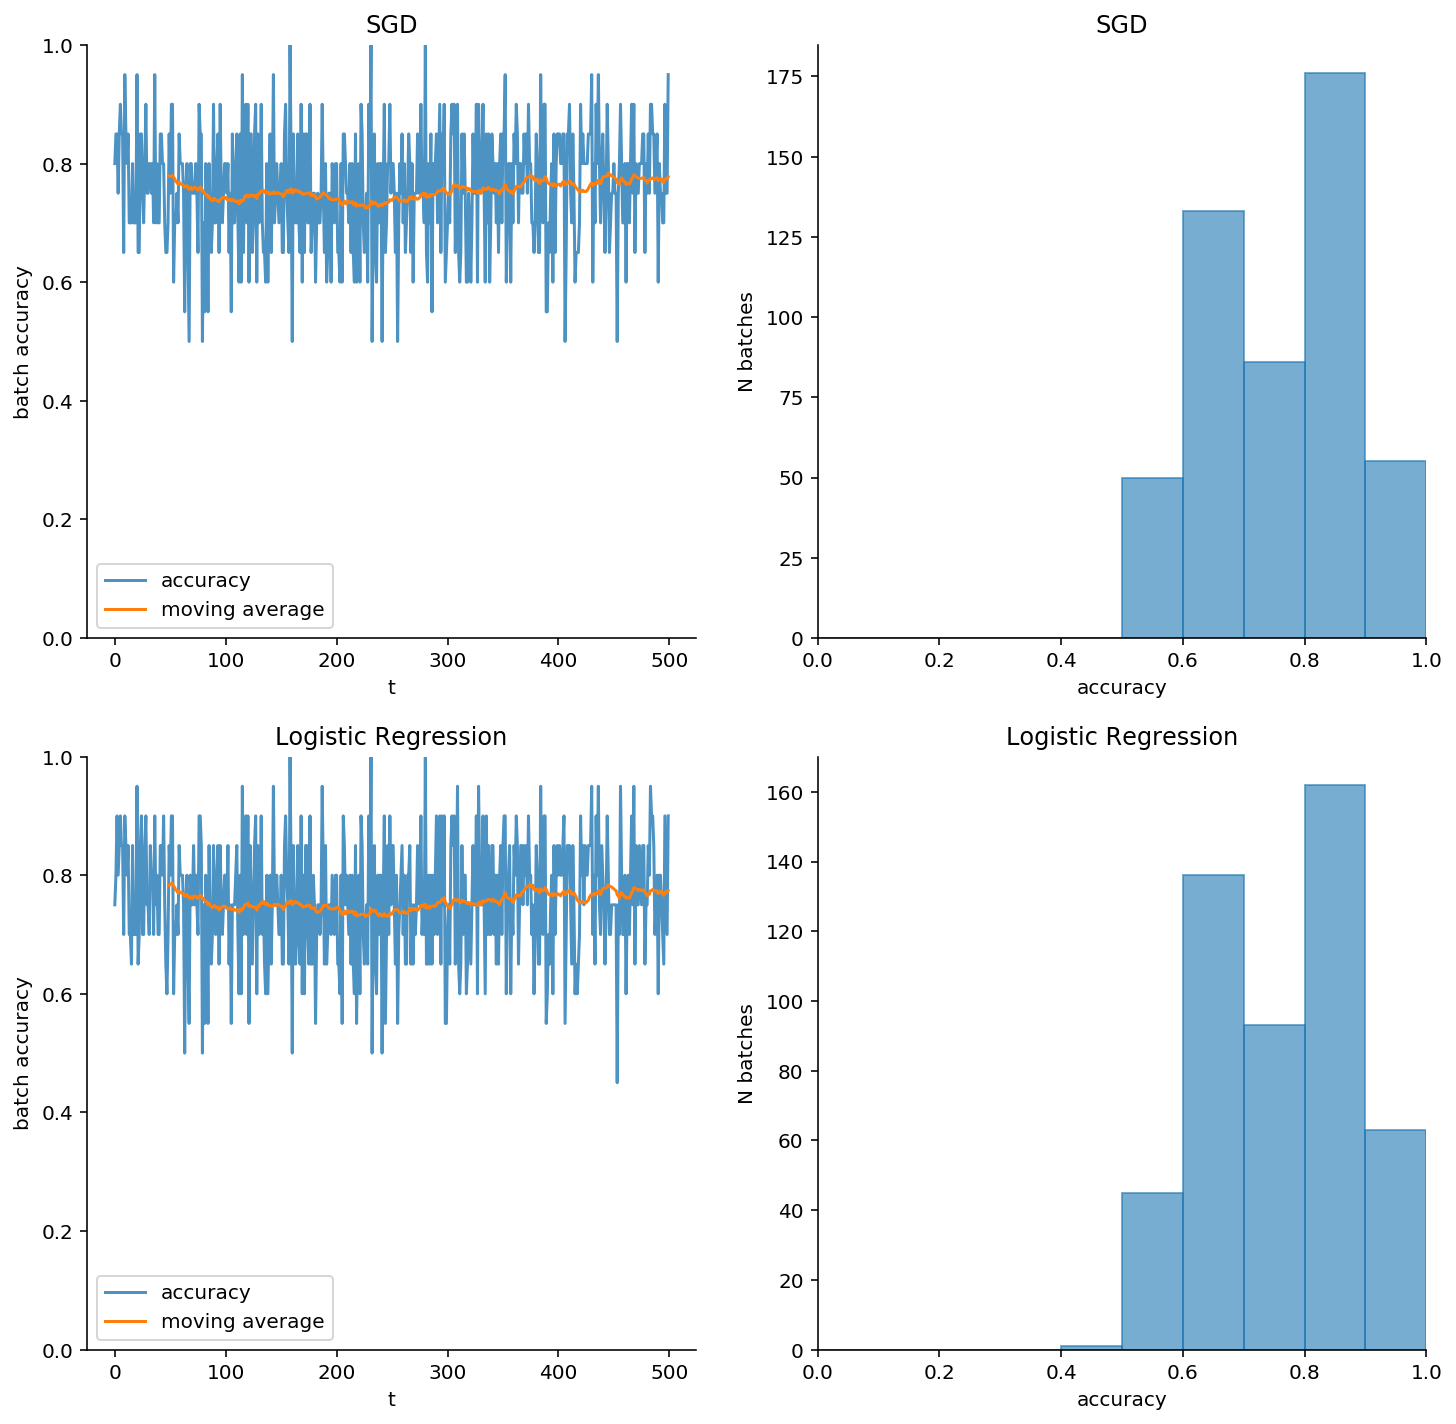

In [18]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N])/ float(N)

f, axarr = plt.subplots(2, 2, figsize = (12,12))

t_int = [(0,99), (700,799), (1400,1499), (1900,1999)]
ax_coord = [[0,0], [0,1], [1,0], [1,1]]

for i in range(2):
    for j in range(2):
        axarr[i,j].spines['top'].set_visible(False)
        axarr[i,j].spines['right'].set_visible(False)
        axarr[i,j].set_xlabel('x1')
        axarr[i,j].set_ylabel('x2')
        
x = update_result[:, 0]
sgd_acc = update_result[:, 1]
lr_acc = update_result[:, 2]

axarr[0,0].plot(x, sgd_acc, label = 'accuracy', alpha = 0.8)
axarr[0,0].plot(x[49:], running_mean(sgd_acc, 50), label = 'moving average')
axarr[0,0].set_ylim(0,1)
axarr[0,0].set_xlabel('t')
axarr[0,0].set_ylabel('batch accuracy')
axarr[0,0].set_title('SGD')
axarr[0,0].legend()


axarr[0,1].hist(sgd_acc, bins = np.arange(0.0,1.1,0.1), alpha = 0.6, edgecolor='C0')
axarr[0,1].set_xlim(0,1)
axarr[0,1].set_xlabel('accuracy')
axarr[0,1].set_ylabel('N batches')
axarr[0,1].set_title('SGD');

axarr[1,0].plot(x, lr_acc, label = 'accuracy', alpha = 0.8)
axarr[1,0].plot(x[49:], running_mean(lr_acc, 50), label = 'moving average')
axarr[1,0].set_ylim(0,1)
axarr[1,0].set_xlabel('t')
axarr[1,0].set_ylabel('batch accuracy')
axarr[1,0].set_title('Logistic Regression')
axarr[1,0].legend()

axarr[1,1].hist(lr_acc, bins = np.arange(0.0,1.1,0.1), alpha = 0.6, edgecolor='C0')
axarr[1,1].set_xlim(0,1)
axarr[1,1].set_xlabel('accuracy')
axarr[1,1].set_ylabel('N batches')
axarr[1,1].set_title('Logistic Regression');

## Summary

Results are comparable. We could go the route of formal statistical testing, to demonstrate this, but that is overkill for this simple demonstration: all we wanted was to get a feeling for how the methods compare (try scipy.stats.ttest_ind if you fancy).

Overall, for a situation like this with distributions that are stationary over time and a large initial batch to train the initial models, I would argue that the batch approach is favourable as it is the simpler approach.